Dependencies


Load models and show them

In [23]:
import clip
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

clip.available_models()

Torch version: 2.3.0+cu121


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

take model

In [24]:
model, preprocess = clip.load("RN50")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [25]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7d7cd1548b80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [26]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

setting up input images


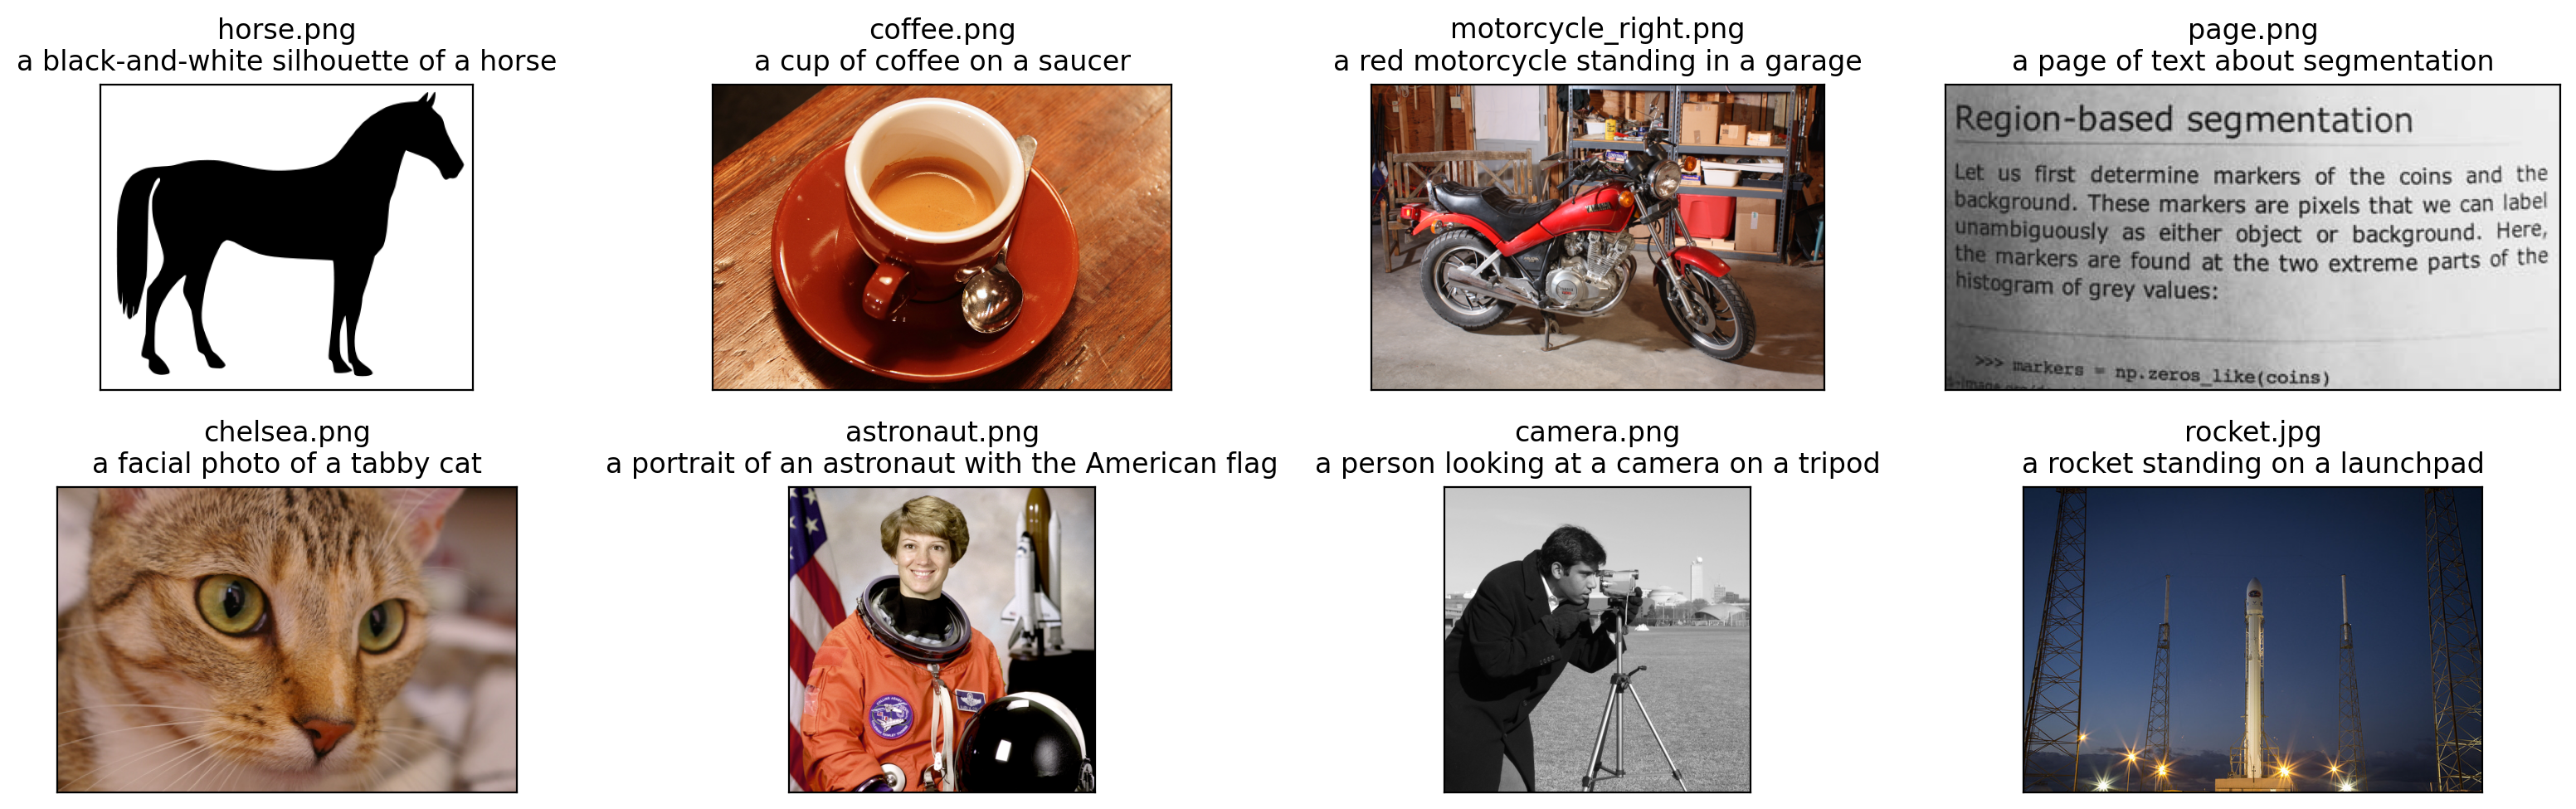

In [27]:
import os
import skimage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}


original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

Augmentations


In [28]:
from torchvision import transforms

def complex_random_augmentation(image):
    # Lista di trasformazioni potenzialmente applicabili
    transform_list = [
        transforms.RandomHorizontalFlip(p=0.5),  # Flip orizzontale con 50% di probabilità
        transforms.RandomVerticalFlip(p=0.2),    # Flip verticale con 20% di probabilità
        transforms.RandomRotation(45),           # Rotazione casuale di ±45 gradi
        transforms.RandomApply([                 # Applica con probabilità del 30% la seguente trasformazione
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
        ], p=0.3),
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.5, 1.0), ratio=(0.75, 1.33)),  # Crop ridimensionato casuale
        transforms.RandomGrayscale(p=0.1),       # Conversione in scala di grigi con 10% di probabilità
        transforms.RandomApply([                 # Applica con probabilità del 40% la seguente trasformazione
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        ], p=0.4)
    ]

    # Componi tutte le trasformazioni
    augmentation = transforms.Compose(transform_list)

    # Applica le trasformazioni all'immagine
    augmented_image = augmentation(image)
    return augmented_image

In [29]:
from torchvision.datasets import CIFAR100


augment_images = [complex_random_augmentation(image) for image in original_images]
_augment_images = [preprocess(image) for image in augment_images]
augment_images_input = torch.tensor(np.stack(_augment_images)).cuda()


text_probs_ = (100.0 * augment_images_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs_.cpu().topk(5, dim=-1)

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

with torch.no_grad():
    augment_images_features = model.encode_image(augment_images_input).float()
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
text_probs = (100.0 * augment_images_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

Files already downloaded and verified


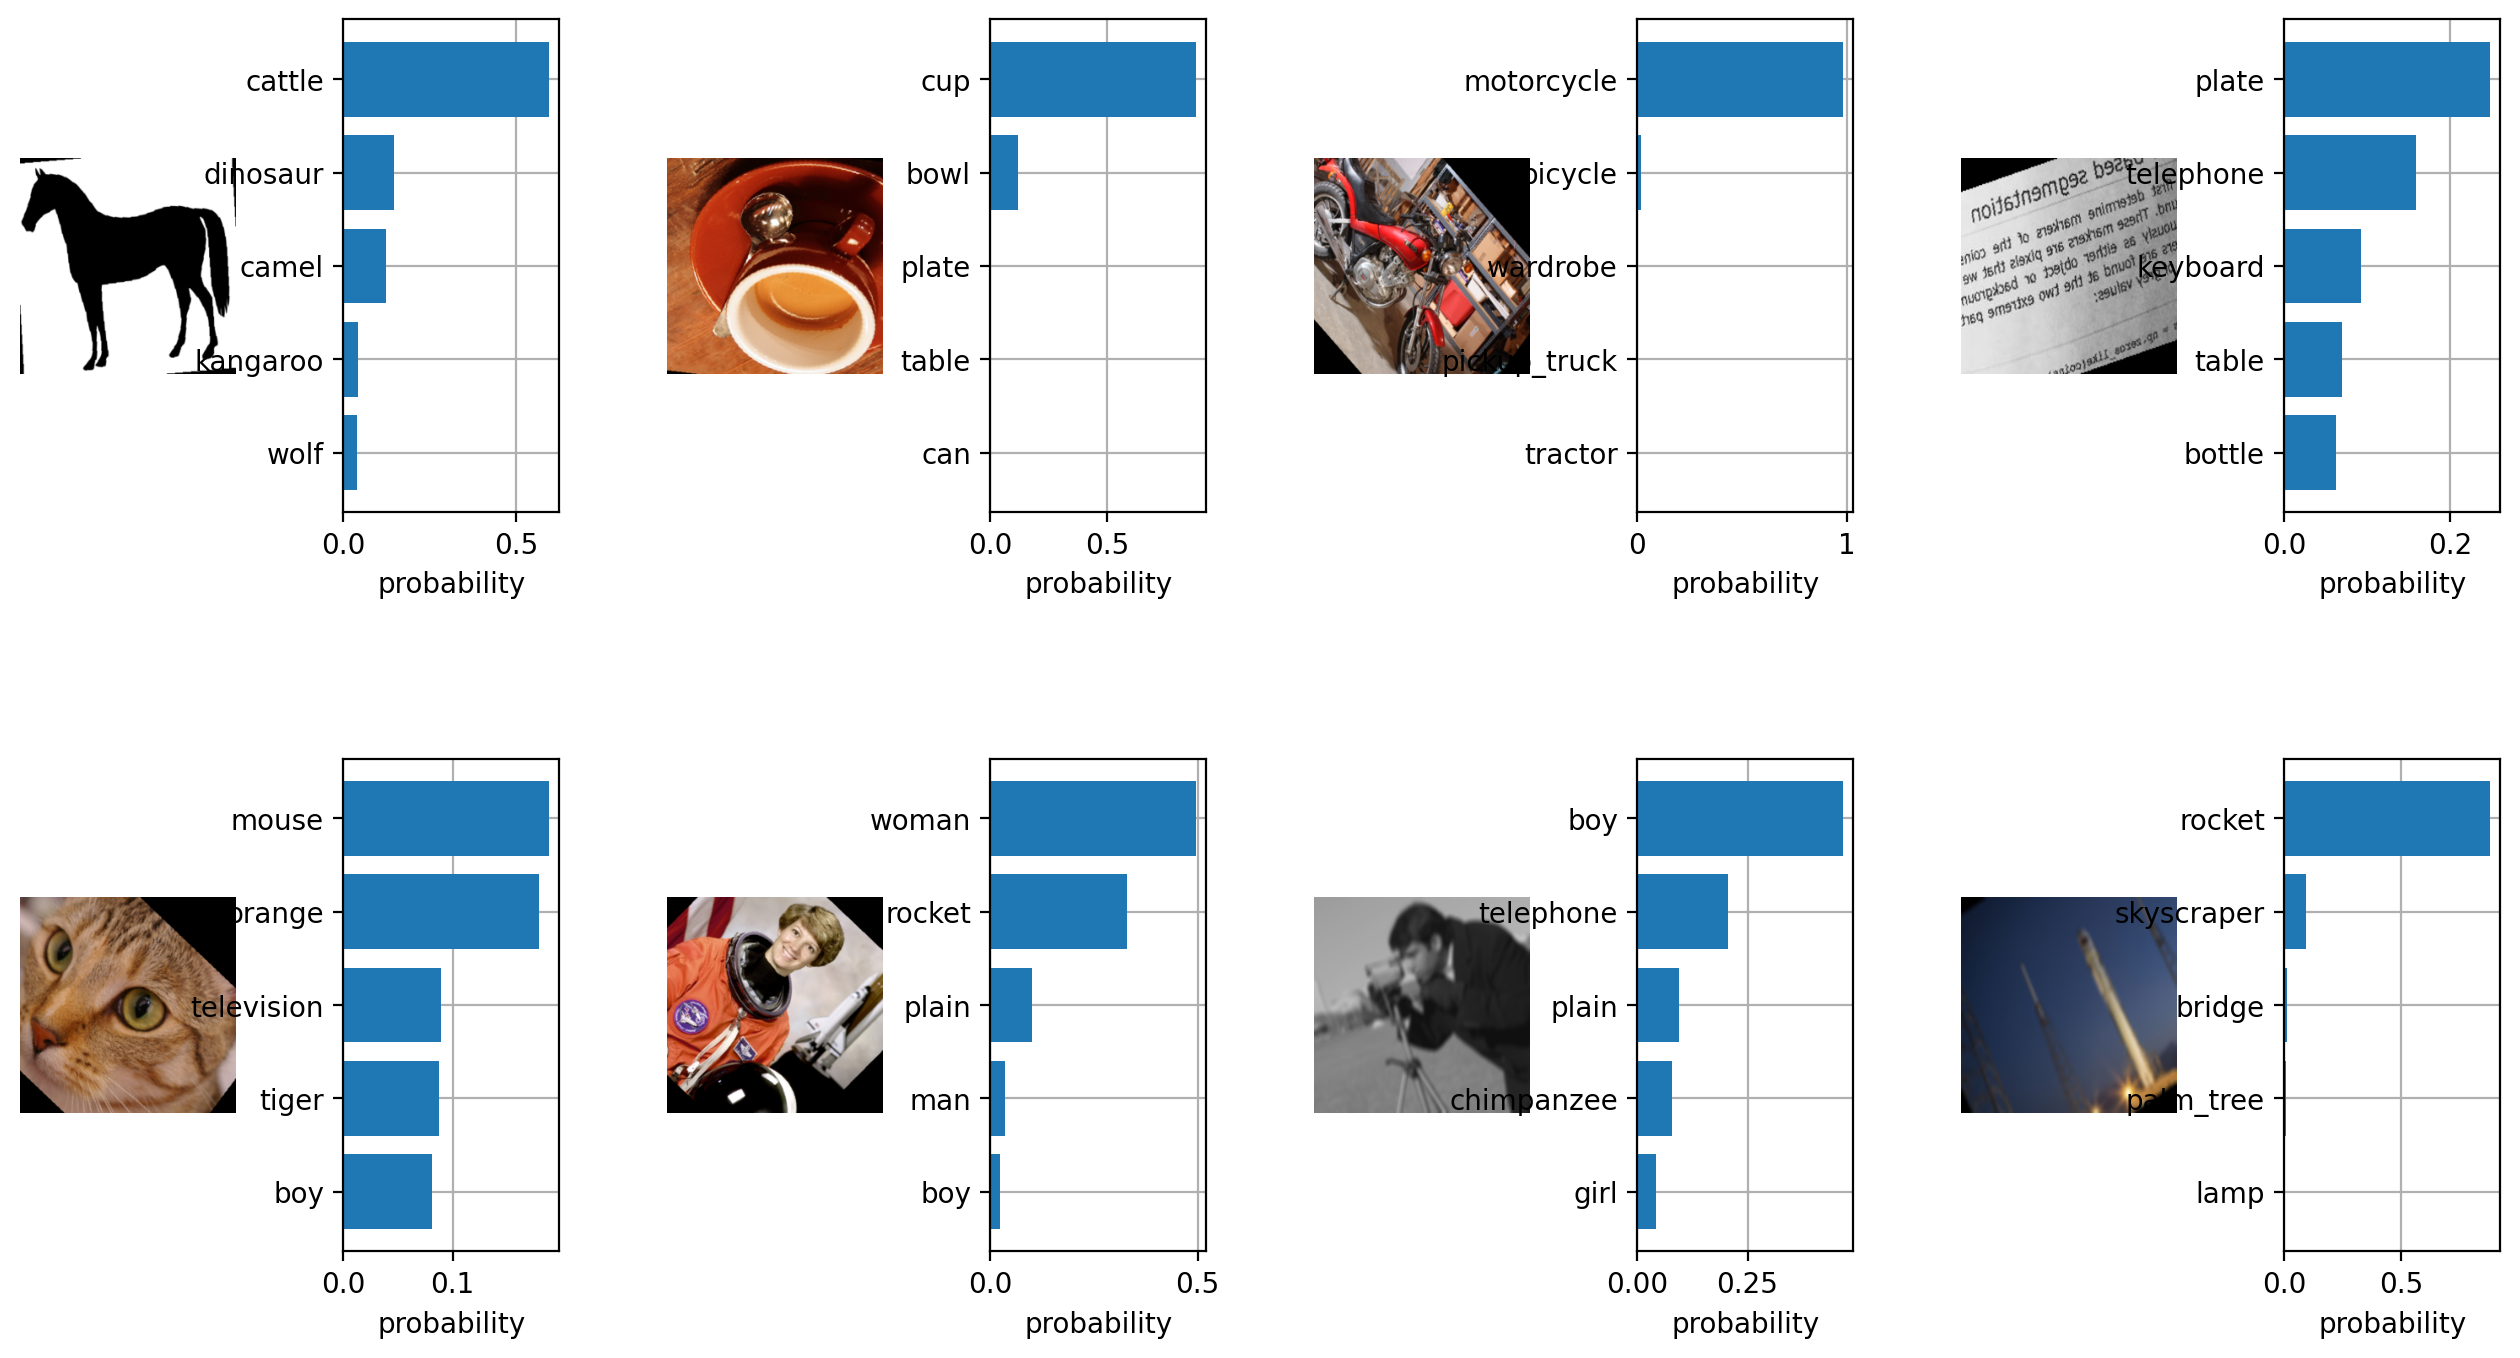

In [30]:
num_images = len(augment_images)
cols = 4  # Definisci il numero di colonne per la griglia di subplot
rows = (num_images + cols - 1) // cols  # Calcola il numero di righe necessarie

plt.figure(figsize=(16, rows * 4))  # Modifica l'altezza in base al numero di righe

for i, image in enumerate(augment_images):
    # Subplot per l'immagine
    plt.subplot(rows, cols * 2, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    # Subplot per il grafico a barre delle probabilità
    plt.subplot(rows, cols * 2, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust lo spazio tra i subplot
plt.show()

# Process the dataset

***NOTE***: SCRIVERE CODICE DICT

In [39]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms
import clip
import torch

wordnet_classes = {
    "n01498041": "stingray",
    "n01531178": "goldfinch",
    "n01534433": "junco",
    "n01558993": "American robin",
    "n01580077": "jay",
    "n01614925": "bald eagle",
    "n01616318": "vulture",
    "n01631663": "newt",
    "n01641577": "American bullfrog",
    "n01669191": "box turtle",
    "n01677366": "green iguana",
    "n01687978": "agama",
    "n01694178": "chameleon",
    "n01698640": "American alligator",
    "n01735189": "garter snake",
    "n01770081": "harvestman",
    "n01770393": "scorpion",
    "n01774750": "tarantula",
    "n01784675": "centipede",
    "n01819313": "sulphur-crested cockatoo",
    "n01820546": "lorikeet",
    "n01833805": "hummingbird",
    "n01843383": "toucan",
    "n01847000": "duck",
    "n01855672": "goose",
    "n01882714": "koala",
    "n01910747": "jellyfish",
    "n01914609": "sea anemone",
    "n01924916": "flatworm",
    "n01944390": "snail",
    "n01985128": "crayfish",
    "n01986214": "hermit crab",
    "n02007558": "flamingo",
    "n02009912": "great egret",
    "n02037110": "oystercatcher",
    "n02051845": "pelican",
    "n02077923": "sea lion",
    "n02085620": "Chihuahua",
    "n02099601": "Golden Retriever",
    "n02106550": "Rottweiler",
    "n02106662": "German Shepherd Dog",
    "n02110958": "pug",
    "n02119022": "red fox",
    "n02123394": "Persian cat",
    "n02127052": "lynx",
    "n02129165": "lion",
    "n02133161": "American black bear",
    "n02137549": "mongoose",
    "n02165456": "ladybug",
    "n02174001": "rhinoceros beetle",
    "n02177972": "weevil",
    "n02190166": "fly",
    "n02206856": "bee",
    "n02219486": "ant",
    "n02226429": "grasshopper",
    "n02231487": "stick insect",
    "n02233338": "cockroach",
    "n02236044": "mantis",
    "n02259212": "leafhopper",
    "n02268443": "dragonfly",
    "n02279972": "monarch butterfly",
    "n02280649": "small white",
    "n02281787": "gossamer-winged butterfly",
    "n02317335": "starfish",
    "n02325366": "cottontail rabbit",
    "n02346627": "porcupine",
    "n02356798": "fox squirrel",
    "n02361337": "marmot",
    "n02410509": "bison",
    "n02445715": "skunk",
    "n02454379": "armadillo",
    "n02486410": "baboon",
    "n02492035": "white-headed capuchin",
    "n02504458": "African bush elephant",
    "n02655020": "pufferfish",
    "n02669723": "academic gown",
    "n02672831": "accordion",
    "n02676566": "acoustic guitar",
    "n02690373": "airliner",
    "n02701002": "ambulance",
    "n02730930": "apron",
    "n02777292": "balance beam",
    "n02782093": "balloon",
    "n02787622": "banjo",
    "n02793495": "barn",
    "n02797295": "wheelbarrow",
    "n02802426": "basketball",
    "n02814860": "lighthouse",
    "n02815834": "beaker",
    "n02837789": "bikini",
    "n02879718": "bow",
    "n02883205": "bow tie",
    "n02895154": "breastplate",
    "n02906734": "broom",
    "n02948072": "candle",
    "n02951358": "canoe",
    "n02980441": "castle",
    "n02992211": "cello",
    "n02999410": "chain",
    "n03014705": "chest",
    "n03026506": "Christmas stocking",
    "n03124043": "cowboy boot",
    "n03125729": "cradle",
    "n03187595": "rotary dial telephone",
    "n03196217": "digital clock",
    "n03223299": "doormat",
    "n03250847": "drumstick",
    "n03255030": "dumbbell",
    "n03291819": "envelope",
    "n03325584": "feather boa",
    "n03355925": "flagpole",
    "n03384352": "forklift",
    "n03388043": "fountain",
    "n03417042": "garbage truck",
    "n03443371": "goblet",
    "n03444034": "go-kart",
    "n03445924": "golf cart",
    "n03452741": "grand piano",
    "n03483316": "hair dryer",
    "n03584829": "clothes iron",
    "n03590841": "jack-o'-lantern",
    "n03594945": "jeep",
    "n03617480": "kimono",
    "n03666591": "lighter",
    "n03670208": "limousine",
    "n03717622": "manhole cover",
    "n03720891": "maraca",
    "n03721384": "marimba",
    "n03724870": "mask",
    "n03775071": "mitten",
    "n03788195": "mosque",
    "n03804744": "nail",
    "n03837869": "obelisk",
    "n03840681": "ocarina",
    "n03854065": "organ",
    "n03888257": "parachute",
    "n03891332": "parking meter",
    "n03935335": "piggy bank",
    "n03982430": "billiard table",
    "n04019541": "hockey puck",
    "n04033901": "quill",
    "n04039381": "racket",
    "n04067472": "reel",
    "n04086273": "revolver",
    "n04099969": "rocking chair",
    "n04118538": "rugby ball",
    "n04131690": "salt shaker",
    "n04133789": "sandal",
    "n04141076": "saxophone",
    "n04146614": "school bus",
    "n04147183": "schooner",
    "n04179913": "sewing machine",
    "n04208210": "shovel",
    "n04235860": "sleeping bag",
    "n04252077": "snowmobile",
    "n04252225": "snowplow",
    "n04254120": "soap dispenser",
    "n04270147": "spatula",
    "n04275548": "spider web",
    "n04310018": "steam locomotive",
    "n04317175": "stethoscope",
    "n04344873": "couch",
    "n04347754": "submarine",
    "n04355338": "sundial",
    "n04366367": "suspension bridge",
    "n04376876": "syringe",
    "n04389033": "tank",
    "n04399382": "teddy bear",
    "n04442312": "toaster",
    "n04456115": "torch",
    "n04482393": "tricycle",
    "n04507155": "umbrella",
    "n04509417": "unicycle",
    "n04532670": "viaduct",
    "n04540053": "volleyball",
    "n04554684": "washing machine",
    "n04562935": "water tower",
    "n04591713": "wine bottle",
    "n04606251": "shipwreck",
    "n07583066": "guacamole",
    "n07695742": "pretzel",
    "n07697313": "cheeseburger",
    "n07697537": "hot dog",
    "n07714990": "broccoli",
    "n07718472": "cucumber",
    "n07720875": "bell pepper",
    "n07734744": "mushroom",
    "n07749582": "lemon",
    "n07753592": "banana",
    "n07760859": "custard apple",
    "n07768694": "pomegranate",
    "n07831146": "carbonara",
    "n09229709": "bubble",
    "n09246464": "cliff",
    "n09472597": "volcano",
    "n09835506": "baseball player",
    "n11879895": "rapeseed",
    "n12057211": "yellow lady's slipper",
    "n12144580": "corn",
    "n12267677": "acorn"
}

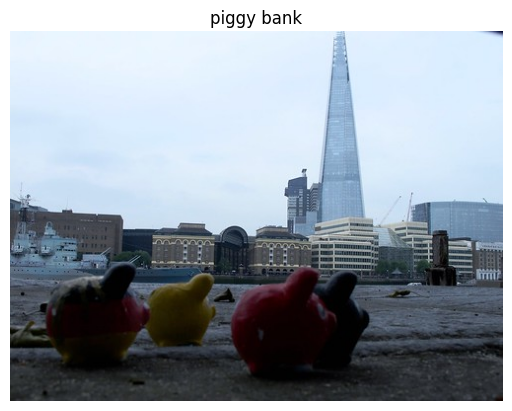

In [32]:

# def read_data(classnames, image_dir):
#     for folder in os.listdir(image_dir):
#         for filename in os.listdir(os.path.join(image_dir, folder)):
#             if filename.endswith(".png") or filename.endswith(".jpg"):
#                 classname = classnames[filename.split("_")[0]]
#                 impath = os.path.join(image_dir, filename)
#                 item = Datum(impath=impath, label=0, classname=classname)
#                 yield item

def pick_random_image(image_dir):
    folder = np.random.choice(os.listdir(image_dir))
    filename = np.random.choice(os.listdir(os.path.join(image_dir, folder)))
    impath = os.path.join(image_dir, folder, filename)
    return impath, folder

ROOT = "./imagenet-a"

image, key_label = pick_random_image(ROOT)

label = wordnet_classes[key_label]

# show image

image = Image.open(image)
plt.imshow(image)
plt.title(f"{label}")
plt.axis("off")
plt.show()

## Utils


In [25]:
def complex_random_augmentation(image):
    # Lista di trasformazioni potenzialmente applicabili
    transform_list = [
        transforms.RandomHorizontalFlip(p=0.5),  # Flip orizzontale con 50% di probabilità
        transforms.RandomVerticalFlip(p=0.2),    # Flip verticale con 20% di probabilità
        transforms.RandomRotation(45),           # Rotazione casuale di ±45 gradi
        transforms.RandomApply([                 # Applica con probabilità del 30% la seguente trasformazione
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
        ], p=0.3),
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.5, 1.0), ratio=(0.75, 1.33)),  # Crop ridimensionato casuale
        transforms.RandomGrayscale(p=0.1),       # Conversione in scala di grigi con 10% di probabilità
        transforms.RandomApply([                 # Applica con probabilità del 40% la seguente trasformazione
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        ], p=0.4)
    ]

    # Componi tutte le trasformazioni
    augmentation = transforms.Compose(transform_list)

    # Applica le trasformazioni all'immagine
    augmented_image = augmentation(image)
    return augmented_image

def visualize_images(images):
    num_images = len(images)
    cols = 4  # Definisci il numero di colonne per la griglia di subplot
    rows = (num_images + cols - 1) // cols  # Calcola il numero di righe necessarie

    plt.figure(figsize=(32, rows * 4))  # Modifica l'altezza in base al numero di righe

    for i, image in enumerate(images):
        # Subplot per l'immagine
        plt.subplot(rows, cols * 2, 2 * i + 1)
        plt.imshow(image)
        plt.axis("off")

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust lo spazio tra i subplot
    plt.show()

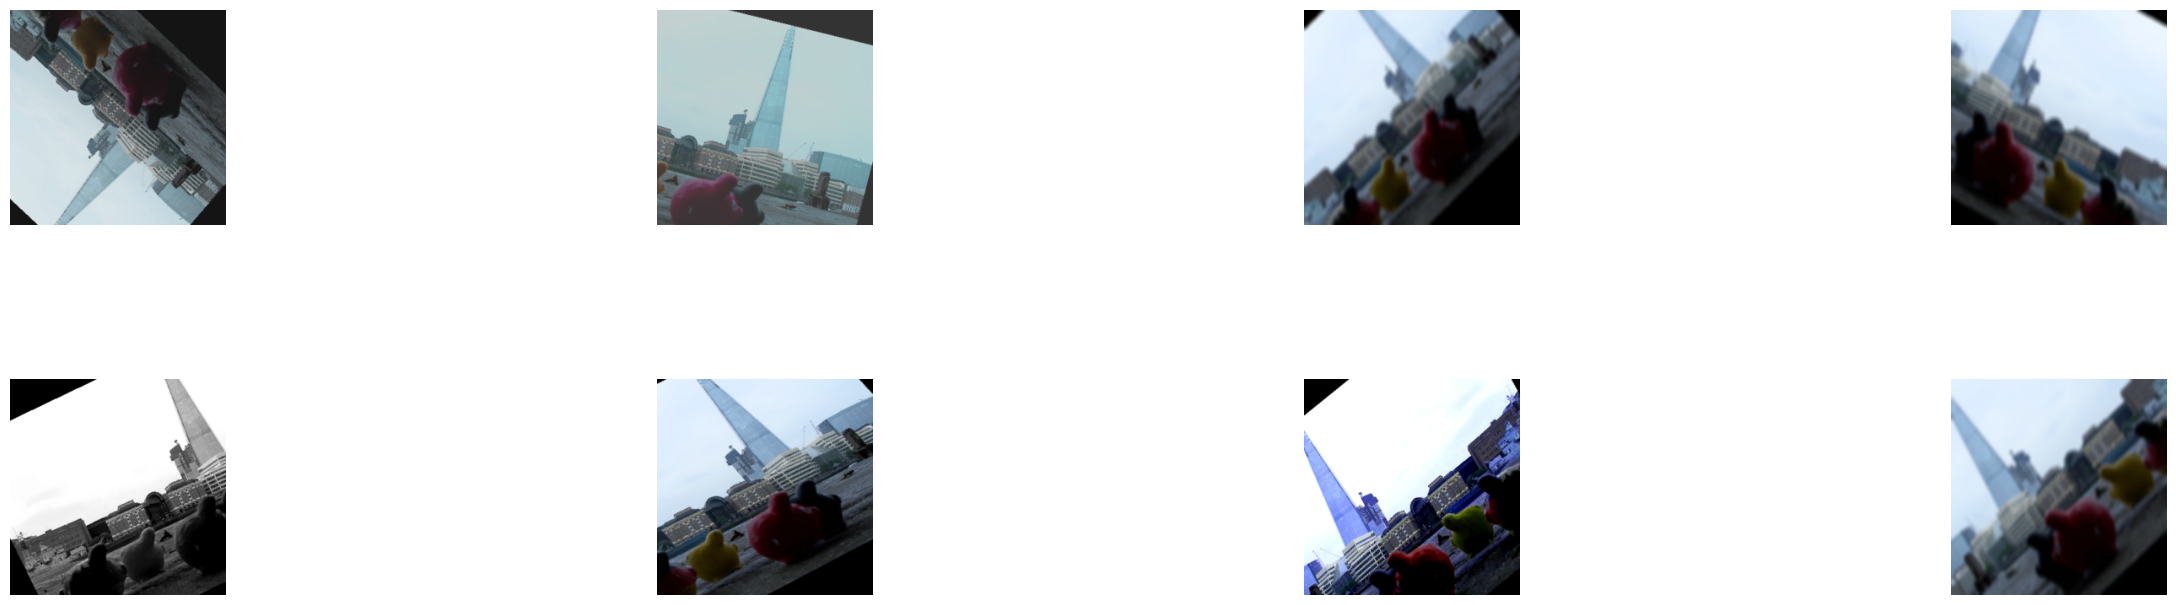

In [33]:
augment_images = [complex_random_augmentation(image) for _ in range(8)]
visualize_images(augment_images)

# LOAD THE MODEL


In [35]:
model, preprocess = clip.load("RN50", device="cuda")

# ENCODE *

In [37]:
text_descriptions = [f"This is a photo of a {label}" for label in wordnet_classes.values()]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [40]:
_augment_images = [preprocess(image) for image in augment_images]
augment_images_input = torch.tensor(np.stack(_augment_images)).cuda()

with torch.no_grad():
    augment_images_features = model.encode_image(augment_images_input).float()
    text_features = model.encode_text(text_tokens).float()
    augment_images_features /= augment_images_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
text_probs = (100.0 * augment_images_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

# DISPLAY THE RESULTS